In [1]:
# ruff: noqa: E402
%run _common.ipynb
%matplotlib inline

import torch
from torch.utils.data import DataLoader
import lightning
from lightning.pytorch.loggers import WandbLogger
import matplotlib.pyplot as plt

from node_homotopy.training import MultipleShootingTraining, VanillaTraining
from node_homotopy.experiments.common import make_trainer
from node_homotopy.experiments.double_pendulum import (
    make_pendulum_dataset,
    make_pendulum_model,
)

## Create the dataset for training

In [2]:
dataset = make_pendulum_dataset()

RANDOM_SEED = 10
lightning.seed_everything(RANDOM_SEED)  # Fix random seed for reproducibility
neuralode = make_pendulum_model(model_type="secondorder")

t, u0, u_true = dataset.t, dataset.u0, dataset.u

# Manually compute the forward pass of the multiple-shooting method
multishoot = MultipleShootingTraining(
    neuralode, lr=2e-2, n_segments=5, continuity_weight=2e-3
)
with torch.no_grad():
    u0_multi, t_multi = multishoot.create_segments(t, u0, u_true)
    u_multi = multishoot.forward(u0_multi, t_multi)

# Also calculate the forward pass of vanilla gradient descent for comparison
vanilla = VanillaTraining(neuralode, lr=2e-2)
with torch.no_grad():
    u_vanilla = vanilla.forward(u0, t)

Seed set to 10


Text(0.5, 0, '$t$')

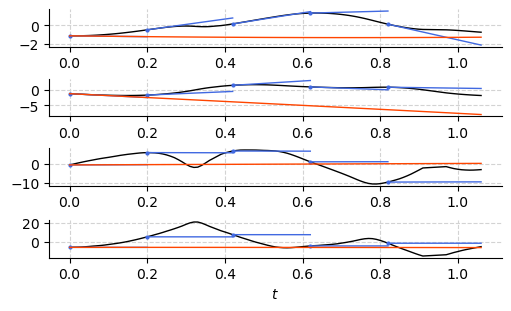

In [3]:
fig, axes = plt.subplots(dataset.n_dim, 1)
for i, ax in enumerate(axes):
    ax.plot(t, u_true[0, i], "-", color="black")
    for t_i, u_multi_i in zip(t_multi, u_multi):
        ax.plot(t_i[0], u_multi_i[0, i, 0], "o", color="royalblue")
        ax.plot(t_i, u_multi_i[0, i], "-", color="royalblue")
    ax.plot(t, u_vanilla[0, i], "-", color="orangered")
axes[-1].set_xlabel("$t$")

## Prepare for training

In [4]:
WANDB_PROJECT = "double_pendulum"
WANDB_ENTITY = "jhelab"  # Change to your wandb username/teamname

dataloader = DataLoader(dataset, batch_size=1, num_workers=8, pin_memory=True)

logger = WandbLogger(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    save_dir=f"../lightning/{WANDB_PROJECT}",
)

# Can also pass None to the logger to only log to the terminal
# logger = None

trainer = make_trainer(max_epochs=4000, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(multishoot, dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jhko725 (jhelab). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | model         | SecondOrderBlackbox | 2.9 K 
1 | loss_function | MSELoss             | 0     
  | other params  | n/a                 | 16    
------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=lyso, train_loss=15.30, mse=34.20]        

/home/jhko725/mambaforge/envs/homotopy/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
